In [33]:

%load_ext autoreload
%autoreload 2

import argparse
from sklearn import metrics
import comet_ml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl
import warmup_scheduler
import numpy as np
import pandas as pd
from torchvision import transforms
import torchmetrics
import matplotlib.pyplot as plt
import seaborn as sns
from utils import get_model, get_dataset, get_experiment_name, get_criterion
from da import CutMix, MixUp
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
class Settings:
    def __init__(self):
        self.dataset = "siim"
        self.num_classes = 2
        self.model_name = "vit"
        self.patch = 8
        self.batch_size = 8
        self.eval_batch_size = 1024
        self.lr = 1e-3
        self.min_lr = 1e-5
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.max_epochs = 3
        self.weight_decay = 5e-5
        self.warmup_epoch = 5
        self.precision = 16
        self.criterion = "ce"
        self.smoothing = 0.1
        self.dropout = 0.0
        self.head = 12
        self.num_layers = 7
        self.hidden = 384
        self.label_smoothing = False
        self.mlp_hidden = 384
        self.seed = 42
        self.project_name = "VisionTransformer"
        self.off_benchmark = False
        self.dry_run = False
        self.autoaugment = False
        self.rcpaste = False
        self.cutmix = False
        self.mixup = False
        self.off_cls_token = False
        self.api_key = False

args = Settings()

torch.manual_seed(args.seed)
np.random.seed(args.seed)
args.benchmark = True if not args.off_benchmark else False
args.gpus = torch.cuda.device_count()
args.num_workers = 4*args.gpus if args.gpus else 8
args.is_cls_token = True if not args.off_cls_token else False
if not args.gpus:
    args.precision=32

if args.mlp_hidden != args.hidden*4:
    print(f"[INFO] In original paper, mlp_hidden(CURRENT:{args.mlp_hidden}) is set to: {args.hidden*4}(={args.hidden}*4)")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[INFO] In original paper, mlp_hidden(CURRENT:384) is set to: 1536(=384*4)


In [34]:
import torch
import torch.utils.data
import torchvision


class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset.train_labels[idx].item()
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [83]:
train_ds, test_ds = get_dataset(args)
# classes = torch.tensor([0, 1, 2])
# indices = (torch.tensor(train_ds.targets)[..., None] == classes).any(-1).nonzero(as_tuple=True)[0]
# train_ds = torch.utils.data.Subset(train_ds, indices)
# test_ds = torch.utils.data.Subset(test_ds, indices)
#print(data.shape)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)#, num_workers=args.num_workers, pin_memory=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=args.eval_batch_size, num_workers=args.num_workers, pin_memory=True)

/dss/dsshome1/lxc09/ra49tad2/ViT-CIFAR/siim.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  oversampled = falseRows.append(trueReplicas[:len(falseRows) - len(trueRows)], ignore_index=True) # 24410 + 23976  = 48386
/dss/dsshome1/lxc09/ra49tad2/ViT-CIFAR/siim.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  oversampled = falseRows.append(trueReplicas[:len(falseRows) - len(trueRows)], ignore_index=True) # 24410 + 23976  = 48386
/dss/dsshome1/lxc09/ra49tad2/vit/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze

In [66]:
from torchsampler import ImbalancedDatasetSampler

train_loader = torch.utils.data.DataLoader(
    train_ds, 
    sampler=ImbalancedDatasetSampler(train_ds),
    batch_size=args.batch_size,
)

In [68]:
next(iter(train_loader))

Appling
Appling
Appling
Appling
Appling


[tensor([[[[   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.0000],
           [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.0000],
           [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.0000],
           ...,
           [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.0000],
           [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.0000],
           [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.0000]],
 
          [[   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.0000],
           [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.0000],
           [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.0000],
           ...,
           [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.00

In [108]:
ex = next(iter(train_loader))

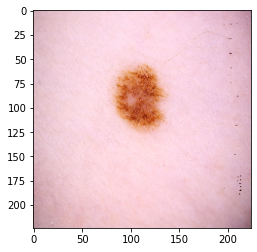

In [61]:
applier = transforms.RandomApply(transforms=[transforms.RandomCrop(size=(64, 64))], p=0.5)
transformed_imgs = applier(train_ds[0][0])
plt.imshow((train_ds[4][0].permute(1, 2, 0)).numpy().astype(np.uint8))
plt.show()

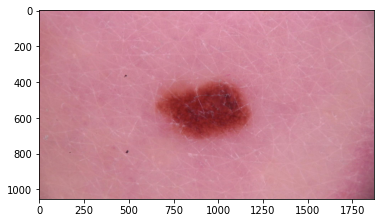

In [17]:
plot_it_somehow = train_ds[1][0]

# img = plot_it_somehow.swapaxes(0, 1)
# img = img.swapaxes(1, 2)

import matplotlib.pyplot as plt

plt.imshow((plot_it_somehow.permute(1, 2, 0)).numpy().astype(np.uint8))
plt.show()

from PIL import Image


# pil_image=Image.fromarray(plot_it_somehow.permute(1, 2, 0).numpy().astype(np.uint8))
# pil_image.show()




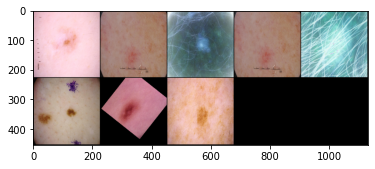

In [82]:
import torchvision

# sample input (10 RGB images containing just Gaussian Noise)
batch_tensor = ex[0]   # (N, C, H, W)

# make grid (2 rows and 5 columns) to display our 10 images
grid_img = torchvision.utils.make_grid(batch_tensor, nrow=5)

grid_img.shape
plt.imshow((grid_img.permute(1, 2, 0)).numpy().astype(np.uint8))
plt.show()

In [3]:
class Net(pl.LightningModule):
    def __init__(self, hparams):
        super(Net, self).__init__()
        # self.hparams = hparams
        self.hparams.update(vars(hparams))
        self.model = get_model(hparams)
        self.criterion = get_criterion(args)
        if hparams.cutmix:
            self.cutmix = CutMix(hparams.size, beta=1.)
        if hparams.mixup:
            self.mixup = MixUp(alpha=1.)
        self.log_image_flag = hparams.api_key is None

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta1, self.hparams.beta2), weight_decay=self.hparams.weight_decay)
        self.base_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.min_lr)
        self.scheduler = warmup_scheduler.GradualWarmupScheduler(self.optimizer, multiplier=1., total_epoch=self.hparams.warmup_epoch, after_scheduler=self.base_scheduler)
        return [self.optimizer], [self.scheduler]

    def training_step(self, batch, batch_idx):
        img, label = batch
        if self.hparams.cutmix or self.hparams.mixup:
            if self.hparams.cutmix:
                img, label, rand_label, lambda_= self.cutmix((img, label))
            elif self.hparams.mixup:
                if np.random.rand() <= 0.8:
                    img, label, rand_label, lambda_ = self.mixup((img, label))
                else:
                    img, label, rand_label, lambda_ = img, label, torch.zeros_like(label), 1.
            out = self.model(img)
            loss = self.criterion(out, label)*lambda_ + self.criterion(out, rand_label)*(1.-lambda_)
        else:
            out = self(img)
            loss = self.criterion(out[:,1], label.float())

        if not self.log_image_flag and not self.hparams.dry_run:
            self.log_image_flag = True
            #self._log_image(img.clone().detach().cpu())

        acc = torch.eq(out.argmax(-1), label).float().mean()
        auc_score = metrics.roc_auc_score(label, out[:, 1].squeeze().detach().numpy())
        self.log('auc', auc_score, on_step=True, on_epoch=True)
        self.log('acc', acc, on_step=True, on_epoch=True)
        self.log('loss', loss,on_step=True, on_epoch=True)
        return loss

    def training_epoch_end(self, outputs):
        #self.log("lr", self.optimizer.param_groups[0]["lr"], on_epoch=self.current_epoch)
        self.log("lr", self.optimizer.param_groups[0]["lr"])

    def validation_step(self, batch, batch_idx):
        img, label = batch
        out = self(img)
        loss = self.criterion(out[:,1], label.float())
        acc = torch.eq(out.argmax(-1), label).float().mean()
        #self.log("val_loss", loss)
        #self.log("val_acc", acc)

        auc_score = metrics.roc_auc_score(label.cpu(), out[:, 1].squeeze())
        self.log('auc', auc_score, on_step=True, on_epoch=True)
        val_acc = torchmetrics.functional.accuracy(out[:, 1], label)
        self.log('valid_acc_from_tmet', val_acc, on_step=True, on_epoch=True)
        self.log('valid_acc', acc, on_step=True, on_epoch=True)
        self.log('val_loss', loss,on_step=True, on_epoch=True)

        # fpr, tpr, thresholds = roc_curve(label, out[:, 1])
        # auc_rf = auc(fpr, tpr)
        # plt.figure(1)
        # plt.plot([0, 1], [0, 1], 'k--')
        # plt.plot(fpr, tpr, label='Vit (area = {:.3f})'.format(auc_rf))
        # plt.xlabel('False positive rate')
        # plt.ylabel('True positive rate')
        # plt.title('ROC curve')
        # plt.legend(loc='best')
        # self.logger.experiment.add_figure('AUC Curve', plt.gcf(), self.current_epoch)

        return { 'loss': loss.item(), 'preds': out, 'target': label}

    def validation_epoch_end(self, outputs):
        preds = torch.cat([tmp['preds'] for tmp in outputs])
        targets = torch.cat([tmp['target'] for tmp in outputs])
        confusion_matrix = torchmetrics.functional.confusion_matrix(preds, targets, num_classes=args.num_classes)

        df_cm = pd.DataFrame(confusion_matrix.cpu().numpy(), index = range(args.num_classes), columns=range(args.num_classes))
        plt.figure(figsize = (args.num_classes,args.num_classes*2))
        fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
        plt.close(fig_)
        
        #self.logger.experiment.add_figure("Confusion matrix", fig_, self.current_epoch)

        # fpr, tpr, thresholds = roc_curve(targets, preds[:, 1])
        # auc_rf = auc(fpr, tpr)
        # plt.figure(1)
        # plt.plot([0, 1], [0, 1], 'k--')
        # plt.plot(fpr, tpr, label='Vit (area = {:.3f})'.format(auc_rf))
        # plt.xlabel('False positive rate')
        # plt.ylabel('True positive rate')
        # plt.title('ROC/AUC curve')
        # plt.legend(loc='best')
        # self.logger.experiment.add_figure('ROC/AUC Curve', plt.gcf(), self.current_epoch)

        # repo_root = os.path.abspath(os.getcwd())
        # data_root = os.path.join(repo_root, "logs")
        # list_of_files = glob.glob(f'{data_root}/*') # * means all if need specific format then *.csv
        # latest_file = max(list_of_files, key=os.path.getctime)
        # writer = SummaryWriter(latest_file)
        # writer.add_figure("Confusion matrix", fig_, self.current_epoch)

    # def _log_image(self, image):
    #     grid = torchvision.utils.make_grid(image, nrow=4)
    #     self.logger.experiment.log_image(grid.permute(1,2,0))
    #     print("[INFO] LOG IMAGE!!!")

In [64]:
experiment_name = get_experiment_name(args)
if args.api_key:
    print("[INFO] Log with Comet.ml!")
    logger = pl.loggers.CometLogger(
        api_key=args.api_key,
        save_dir="logs",
        project_name=args.project_name,
        experiment_name=experiment_name
    )
    refresh_rate = 0
else:
    print("[INFO] Log with CSV")
    logger = pl.loggers.CSVLogger(
        save_dir="logs",
        name=experiment_name
    )
    #logger = TensorBoardLogger(name="vit_siim",save_dir="logs")
    refresh_rate = 1
args.model_name = 'vit'
args.experiment_name = 'vit_siim'    
net = Net(args)
trainer = pl.Trainer(precision=args.precision,fast_dev_run=args.dry_run, gpus=args.gpus, benchmark=args.benchmark,logger=logger, max_epochs=args.max_epochs)
trainer.fit(model=net, train_dataloader=train_dl, val_dataloaders=test_dl)
if not args.dry_run:
    model_path = f"weights/{experiment_name}.pth"
    torch.save(net.state_dict(), model_path)
    if args.api_key:
        logger.experiment.log_asset(file_name=experiment_name, file_data=model_path)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
c:\Users\HP\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:733: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ViT               | 6.3 M 
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.063    Total estimated model params size (MB)


Experiment:vit_siim
[INFO] Log with CSV
Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([15, 64, 48])
                                                                      

c:\Users\HP\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:412: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1:  50%|█████     | 1/2 [00:21<00:21, 21.60s/it, loss=20.5, v_num=49]torch.Size([15, 64, 48])


Exception ignored in: <function _ConnectionBase.__del__ at 0x0000011349C9E670>
Traceback (most recent call last):
  File "c:\Users\HP\anaconda3\lib\multiprocessing\connection.py", line 132, in __del__
    self._close()
  File "c:\Users\HP\anaconda3\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid


Epoch 2: 100%|██████████| 2/2 [00:49<00:00, 24.89s/it, loss=14.7, v_num=49]


In [4]:
import os
from siim import SIIM
import torchvision.transforms as transforms
df_test = pd.read_csv(os.path.join('D:/Workspace/cv_attention/data/siim', 'test.csv'))
df_test['filepath'] = df_test['image_name'].apply(lambda x: os.path.join('data/siim', 'test', f'{x}.jpg'))
n_test = 8
# repo_root = os.path.abspath(os.getcwd())
# data_root = os.path.join(repo_root, "data/siim")
data_root = "D:/Workspace/cv_attention/data/siim"
test_transform = []
if args.dataset == 'siim': 
        test_transform += [transforms.Resize(size=(32, 32))]
test_transform = transforms.Compose(test_transform)

test_ds = SIIM(data_root, purpose='test', seed=args.seed, split=0.7, transforms=test_transform)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=args.batch_size, num_workers=args.num_workers)

In [7]:
from tqdm.notebook import tqdm
OUTPUTS = []


model = net
model.load_state_dict(torch.load(os.path.join('weights/vit_siim.pth')), strict=True)
model.eval()

LOGITS = []
PROBS = []

with torch.no_grad():
    for (data) in tqdm(test_loader):         
        data = data#.to(device)
        logits = torch.zeros((data.shape[0], 2))#.to(device)
        probs = torch.zeros((data.shape[0], 2))#.to(device)
        for I in range(n_test):
            l = model(data)
            logits += l
            probs += l.softmax(1)
        logits /= n_test
        probs /= n_test

        LOGITS.append(logits.detach().cpu())
        PROBS.append(probs.detach().cpu())

LOGITS = torch.cat(LOGITS).numpy()
PROBS = torch.cat(PROBS).numpy()

OUTPUTS.append(PROBS[:, 1])

  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
pred = np.zeros(OUTPUTS[0].shape[0])
for probs in OUTPUTS:
    pred += pd.Series(probs).rank(pct=True).values
pred /= len(OUTPUTS)

In [1]:
# df_test['target'] = pred
# df_test[['image_name', 'target']].to_csv(f'submission.csv', index=False)
pred

NameError: name 'pred' is not defined

In [4]:
experiment_name = get_experiment_name(args)
if args.api_key:
    print("[INFO] Log with Comet.ml!")
    logger = pl.loggers.CometLogger(
        api_key=args.api_key,
        save_dir="logs",
        project_name=args.project_name,
        experiment_name=experiment_name
    )
    refresh_rate = 0
else:
    print("[INFO] Log with CSV")
    logger = pl.loggers.CSVLogger(
        save_dir="logs",
        name=experiment_name
    )
    #logger = TensorBoardLogger(name="vit_siim",save_dir="logs")
    refresh_rate = 1
args.model_name = 'cnn'
args.experiment_name = 'cnn_siim'
net = Net(args)
trainer = pl.Trainer(precision=args.precision,fast_dev_run=args.dry_run, gpus=args.gpus, benchmark=args.benchmark,logger=logger, max_epochs=args.max_epochs)
trainer.fit(model=net, train_dataloader=train_dl, val_dataloaders=test_dl)
if not args.dry_run:
    model_path = f"weights/{args.experiment_name}.pth"
    torch.save(net.state_dict(), model_path)
    if args.api_key:
        logger.experiment.log_asset(file_name=args.experiment_name, file_data=model_path)

GPU available: False, used: False


Experiment:vit_siim
[INFO] Log with CSV


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
c:\Users\HP\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:733: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

  | Name      | Type              | Params
------------------------------------------------
0 | model     | CNNEmbedder       | 11.2 M
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


c:\Users\HP\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:412: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 2: 100%|██████████| 2/2 [00:35<00:00, 17.73s/it, loss=7.59, v_num=52]


In [5]:
experiment_name = get_experiment_name(args)
if args.api_key:
    print("[INFO] Log with Comet.ml!")
    logger = pl.loggers.CometLogger(
        api_key=args.api_key,
        save_dir="logs",
        project_name=args.project_name,
        experiment_name=experiment_name
    )
    refresh_rate = 0
else:
    print("[INFO] Log with CSV")
    logger = pl.loggers.CSVLogger(
        save_dir="logs",
        name=experiment_name
    )
    #logger = TensorBoardLogger(name="vit_siim",save_dir="logs")
    refresh_rate = 1
args.model_name = 'vit_emb'
args.experiment_name = 'vit_emb_siim'
net = Net(args)
trainer = pl.Trainer(precision=args.precision,fast_dev_run=args.dry_run, gpus=args.gpus, benchmark=args.benchmark,logger=logger, max_epochs=args.max_epochs)
trainer.fit(model=net, train_dataloader=train_dl, val_dataloaders=test_dl)
if not args.dry_run:
    model_path = f"weights/{args.experiment_name}.pth"
    torch.save(net.state_dict(), model_path)
    if args.api_key:
        logger.experiment.log_asset(file_name=args.experiment_name, file_data=model_path)

Experiment:cnn_siim
[INFO] Log with CSV
[INFO] In original paper, mlp_hidden(CURRENT:384) is set to: 1536(=384*4)
[INFO] In original paper, mlp_hidden(CURRENT:384) is set to: 1536(=384*4)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
c:\Users\HP\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:733: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ViTEmbedded       | 6.4 M 
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
6.4 M     Trainable params
0         Non-trainable params
6.4 M     Total params
25.718    Total estimated model params size (MB)


c:\Users\HP\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:412: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 2: 100%|██████████| 2/2 [00:40<00:00, 20.02s/it, loss=6.02, v_num=6]


In [7]:

model = Net(args)
model.load_state_dict(torch.load(os.path.join('weights/vit_siim.pth')), strict=True)
model.eval()

Net(
  (model): CNNEmbedder(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, e

In [74]:

%load_ext autoreload
%autoreload 2
from vit_embedded import ViTEmbedded
#newmodel = model.model.feature_extractor
ex = ViTEmbedded(64, 
            2, 
            img_size=8, 
            patch=8, 
            dropout=args.dropout, 
            mlp_hidden=args.mlp_hidden,
            num_layers=args.num_layers,
            hidden=args.hidden,
            head=args.head,
            is_cls_token=args.is_cls_token)

dl = next(iter(train_dl))

ex.forward(dl[0])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[INFO] In original paper, mlp_hidden(CURRENT:384) is set to: 1536(=384*4)
torch.Size([18, 64, 64])


tensor([[0.0330, 0.2103],
        [0.0416, 0.1959],
        [0.0696, 0.1884],
        [0.0299, 0.1978],
        [0.0998, 0.2405],
        [0.0849, 0.1958],
        [0.0594, 0.2101],
        [0.0536, 0.2129],
        [0.0657, 0.2052],
        [0.0466, 0.2072],
        [0.0310, 0.2032],
        [0.0554, 0.2013],
        [0.0666, 0.2079],
        [0.0291, 0.2014],
        [0.0370, 0.2012],
        [0.0427, 0.2030],
        [0.0389, 0.1970],
        [0.0449, 0.2048]], grad_fn=<AddmmBackward0>)

In [47]:

%load_ext autoreload
%autoreload 2
import torchvision.models as models
res = models.resnet18(pretrained=False)
res = nn.Sequential(*list(res.children())[:-4])
d = res.forward(dl[0])
d.shape
res

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [12]:
dl[0].shape

torch.Size([18, 3, 32, 32])

In [26]:
import torchvision.models as models
#mo = models.resnet18(pretrained=False)
model.model.classifier = model.model.feature_extractor
print(model.model.classifier)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [28]:
from model.attention.CoAtNet import CoAtNet
import torch
from torch import nn
from torch.nn import functional as F

input=torch.randn(1,3,224,224)
mbconv=CoAtNet(in_ch=3,image_size=224)
out=mbconv(input)
print(out.shape)

torch.Size([1, 768, 14, 14])


In [70]:
import torch
from PIL import Image
from torchvision import transforms
#import torchvision
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torchvision.io import read_image
import math
from sklearn.model_selection import train_test_split
class HAM(Dataset):
    """HAM dataset class"""

    def __init__(self, root, purpose, seed, split, transforms=None, tfm_on_patch=None):
        self.root_path = root
        self.purpose = purpose
        self.seed = seed
        self.split = split
        self.img_part1 = os.listdir(f'{root}/HAM10000_images_part_1/')
        self.img_part2 = os.listdir(f'{root}/HAM10000_images_part_2/')
        self.images, self.labels = self._make_dataset(directory=self.root_path, purpose=self.purpose, seed=self.seed, split=self.split)
        self.transforms = transforms
        self.tfm_on_patch = tfm_on_patch

    def _make_dataset(self,directory, purpose, seed, split):
        """
        Create the image dataset by preparing a list of samples
        :param directory: root directory of the dataset
        :returns: (images, labels) where:
            - images is a numpy array containing all images in the dataset
            - labels is a list containing one label per image
        """

        data_path = os.path.join(directory, "HAM10000_metadata.csv")
        meta_df = pd.read_csv(data_path)
        # meta_df.rename(columns={'image_id': 'image_name'})
        meta_df['target'] = pd.Categorical(meta_df['dx']).codes
        meta_df['image_name'] = meta_df.apply(lambda row: self.extract_path_img(directory,row.image_id), axis=1)

        
    
        #(33126, 8)
        
        train, val = train_test_split(meta_df, test_size=split, random_state=seed)
        #do we want to apply stratification here?
        # train, val, test = np.split(meta_df.sample(frac=1, random_state=seed), 
        #                                 [int(split*meta_df.shape[0]), int(((1.0-split)/2.0+split)*meta_df.shape[0])])

        #train -> 24844
        #val -> 8282
        # trueRows = train[train['target'] == 1] # 434
        # falseRows = train[train['target'] == 0] # 24410
        # # # print(len(trueRows))
        # # # print(f" = > {len(falseRows) - len(trueRows)}")
        # trueReplicas = pd.concat([trueRows]*(math.ceil(len(falseRows)/len(trueRows)))) # 434*57 = 24738


        
        
        # oversampled = falseRows.append(trueReplicas[:len(falseRows) - len(trueRows)], ignore_index=True) # 24410 + 23976  = 48386
        ######################

        if purpose=='train':
            return train['image_name'].tolist(), train['target'].tolist()
        elif purpose=='val':
            return val['image_name'].tolist(), val['target'].tolist()
        elif purpose=='test':
            data_path = os.path.join(directory, "test.csv")
            test_df = pd.read_csv(data_path, sep=',')

            return test_df['image_name'].tolist(), []

    def extract_path_img(self,directory,x):
        file = x + '.jpg'
        
        if file in self.img_part1:
            
            return os.path.join(f'{directory}/HAM10000_images_part_1', file)
        
        elif file in self.img_part2:
            
            return os.path.join(f'{directory}/HAM10000_images_part_2', file)
    def __len__(self):
        """Return number of images in the dataset"""
        return(len(self.images))
        
    def get_labels(self): return self.labels

    def __getitem__(self, index):
        """
        Creates a dict of the data at the given index:
            {"image": <i-th image>,                                              #
             "label": <label of i-th image>} 
        """

        img_root = self.images[index]
        
        #img = Image.open(img_root)
        #trans = transforms.ToTensor()
        #img = trans(img)
        #img = torchvision.io.read_image(img_root)
        img = read_image(img_root)
        if self.transforms is not None:
            img = self.transforms(img)


        if self.labels[index] == 1:
            transformForReplicas = transforms.RandomChoice([
                transforms.RandomHorizontalFlip(), 
                transforms.RandomVerticalFlip(),
                transforms.RandomAutocontrast(),
                transforms.RandomAdjustSharpness(sharpness_factor=2),
                transforms.RandomEqualize()
            ])

            transformForReplicas2 = transforms.RandomChoice([
                transforms.ColorJitter(brightness=.5, hue=.3),
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                transforms.RandomRotation(degrees=(0, 180)),
                transforms.RandomPosterize(bits=2),
                
            ])

            img = transformForReplicas(img)
            img = transformForReplicas2(img)
        img = img.float()

        
        if self.purpose == 'test':
            return img
        else:
            return img, self.labels[index]
        return img, torch.tensor([self.labels[index]])


        data_dict = {
            'image': img,
            'label': torch.tensor([self.labels[index]])
        }

        


        # if self.tfm_on_patch is None: return data_dict

        # for tfm in self.tfm_on_patch:
        #     data_dict = tfm(data_dict)

        

        return data_dict

In [71]:

base_path = "/dss/dssmcmlfs01/pn69za/pn69za-dss-0002/ra49tad2/data/ham"
train_ds = HAM(base_path, purpose='train', seed=42, split=0.25)



# train, val = train_test_split(meta_df, test_size=split, random_state=seed)

In [49]:
meta_df['cancer_idx'] = pd.Categorical(meta_df['dx']).codes
meta_df['image'][0]

'/dss/dssmcmlfs01/pn69za/pn69za-dss-0002/ra49tad2/data/ham//HAM10000_images_part_1/ISIC_0027419.jpg'

In [27]:
img_part1 = os.listdir(f'{base_path}/HAM10000_images_part_1/')
img_part2 = os.listdir(f'{base_path}/HAM10000_images_part_2/')